# Reading the input example image

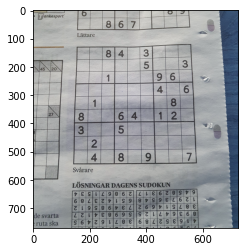

In [1]:
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.colors import LogNorm
import hough
from hough_accumulator import HoughAccumulator


image_path = Path(os.path.abspath('')).joinpath("example.png")
assert image_path.is_file()
img = cv2.imread(str(image_path))
plt.imshow(img)

# Finding the large Sudoku box

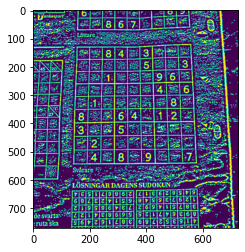

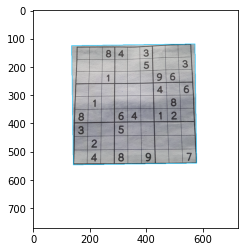

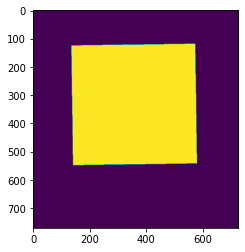

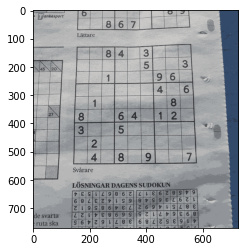

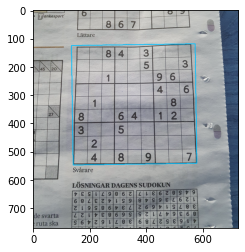

In [2]:
import cv2
import numpy as np

# Kmeans color segmentation
def kmeans_color_quantization(image, clusters=8, rounds=1):
    h, w = image.shape[:2]
    samples = image.reshape((w*h, 3)).astype(np.float32)

    compactness, labels, centers = cv2.kmeans(samples,
            clusters, 
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
            rounds, 
            cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return res.reshape((image.shape))

# Load image and perform kmeans
img2 = img.copy()
kmeans = kmeans_color_quantization(img2, clusters=8)

# Convert to grayscale, Gaussian blur, adaptive threshold
gray = cv2.cvtColor(kmeans, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,21,2)

# Draw largest enclosing rectangle onto a mask
mask = np.zeros(img2.shape[:2], dtype=np.uint8)
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
for c in cnts:
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img2,[box],0, color=(0,191,255), thickness=2)
    cv2.drawContours(mask,[box],0, color=255, thickness=-1)
    break

# Bitwise-and for result
result = cv2.bitwise_and(img2, img2, mask=mask)
result[mask==0] = (255,255,255)

plt.figure()
plt.imshow(thresh)
plt.figure()
plt.imshow(result)
plt.figure()
plt.imshow(mask)
plt.figure()
plt.imshow(kmeans)
plt.figure()
plt.imshow(img2)

# Rectifying the box from the corners into a rectangular image of fixed size

Drawing point [130.6851  121.31644]
Drawing point [575.48926  115.051575]
Drawing point [581.55524 545.7366 ]
Drawing point [136.7511 552.0014]


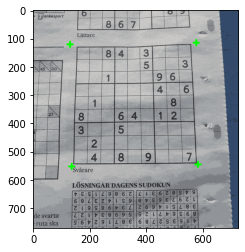

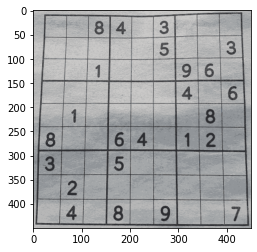

In [3]:
import math

def rect_to_points(x0, y0, width, height, angle):
    _angle = angle * math.pi / 180.0
    b = math.cos(_angle) * 0.5
    a = math.sin(_angle) * 0.5
    pt0 = (
        x0 - a * height - b * width,
        y0 + b * height - a * width,
    )
    pt1 = (
        x0 + a * height - b * width,
        y0 - b * height - a * width,
    )
    pt2 = (
        2 * x0 - pt0[0],
        2 * y0 - pt0[1],
    )
    pt3 = (
        2 * x0 - pt1[0],
        2 * y0 - pt1[1],
    )
    return np.float32([
        pt0, pt1, pt2, pt3
    ])

# Expanding 2% to make sure that we get all outer edges
pts1 = rect_to_points(*rect[0], *np.array(rect[1]) * 1.02, rect[2])

img_points = kmeans.copy()
for pt in pts1:
    print(f"Drawing point {pt}")
    img_points = cv2.drawMarker(img_points, pt.astype(int), [0, 255, 0], thickness=5)
plt.imshow(img_points)

pts2 = np.float32([[0,0],[450,0],[450,450],[0,450]])
matrix = cv2.getPerspectiveTransform(pts1,pts2)
imagewrap = cv2.warpPerspective(kmeans,matrix,(450,450))

plt.figure()
plt.imshow(imagewrap)

# Getting Hough accumulator from image

Text(0.5, 0, 'Offset [px]')

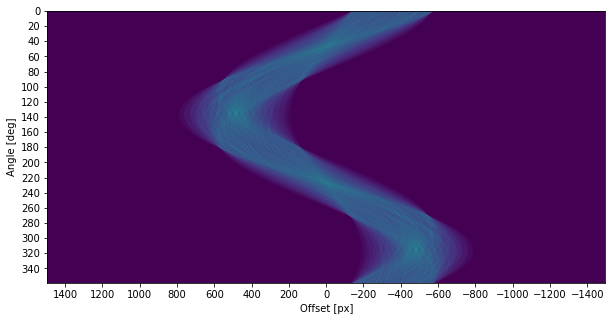

In [4]:
import scipy.ndimage

img_canny = cv2.bitwise_and(thresh, thresh, mask=mask)
accum = HoughAccumulator(img_canny)

fig = plt.figure()
fig.set_size_inches(10, 5)
local_maxes = scipy.ndimage.maximum_filter(accum, size=5)
plt.imshow(accum.acc, extent=[accum.col_to_rho(-1), accum.col_to_rho(0), accum.row_to_theta(-1), accum.row_to_theta(0)])  #, norm=LogNorm(vmin=1, vmax=1e2))
ax = plt.gca()
ax.set_aspect(aspect="auto")
ax.locator_params(nbins=20)
ax.set_ylabel("Angle [deg]")
ax.set_xlabel("Offset [px]")

# Distribution of Hough line intensities

(array([0.81792834, 0.81842399, 0.81884725, 0.81940046, 0.81992953,
        0.82043076, 0.82094127, 0.82139794, 0.82187318, 0.82249507,
        0.823388  , 0.82444057, 0.82552842, 0.82657914, 0.82758717,
        0.82843554, 0.82927649, 0.8300636 , 0.83083957, 0.83155614,
        0.83229313, 0.83313779, 0.83388963, 0.83471759, 0.83559195,
        0.83653871, 0.83750032, 0.83839882, 0.83932702, 0.84019581,
        0.84102191, 0.84180531, 0.84252745, 0.84327372, 0.84399029,
        0.84468644, 0.84539001, 0.84608802, 0.84681758, 0.84763996,
        0.84847163, 0.84922533, 0.850031  , 0.85084039, 0.85158109,
        0.85239605, 0.85318316, 0.85399441, 0.85477224, 0.85553707,
        0.85630934, 0.85705375, 0.85787613, 0.85862983, 0.85935011,
        0.86011495, 0.86090763, 0.8616836 , 0.86244844, 0.86317429,
        0.86395212, 0.8647745 , 0.86564887, 0.86642113, 0.86721752,
        0.86799906, 0.86883816, 0.86965683, 0.87050706, 0.87130345,
        0.87214254, 0.87295007, 0.87380216, 0.87

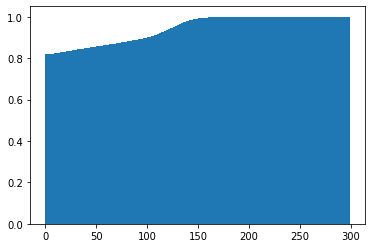

In [5]:
plt.hist(accum.acc.flatten(), bins=range(0, 300), cumulative=True, density=True)

# Finding angles with most prominent lines

[ 45  91 135 225 271 315 349]


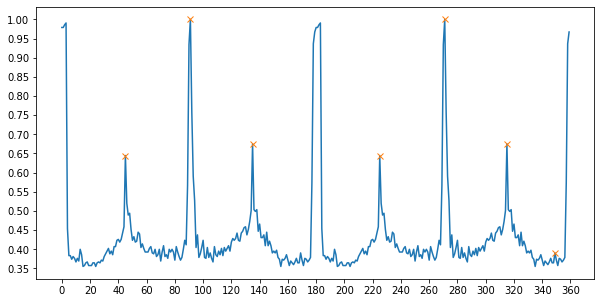

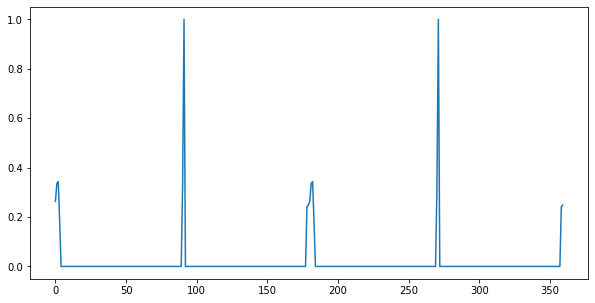

In [6]:
import scipy.signal

fig = plt.figure()
fig.set_size_inches(10, 5)
plt.locator_params(nbins=20)
ys1 = np.amax(accum.acc, axis=1)
angles = np.arange(180)
peaks, _ = scipy.signal.find_peaks(ys1, distance=30, prominence=10, width=(None, 5))
print(peaks)
plt.plot(ys1 / np.amax(ys1))
plt.plot(peaks, ys1[peaks] / np.amax(ys1), 'x')
fig = plt.figure()
fig.set_size_inches(10, 5)
thresh = np.amax(accum.acc.flatten()) * 0.8
accum2 = accum.acc.copy()
accum2[accum.acc < thresh] = 0
ys2 = np.sum(accum2, axis=1)
plt.plot(ys2 / np.amax(ys2))

# Detecting and drawing Hough lines

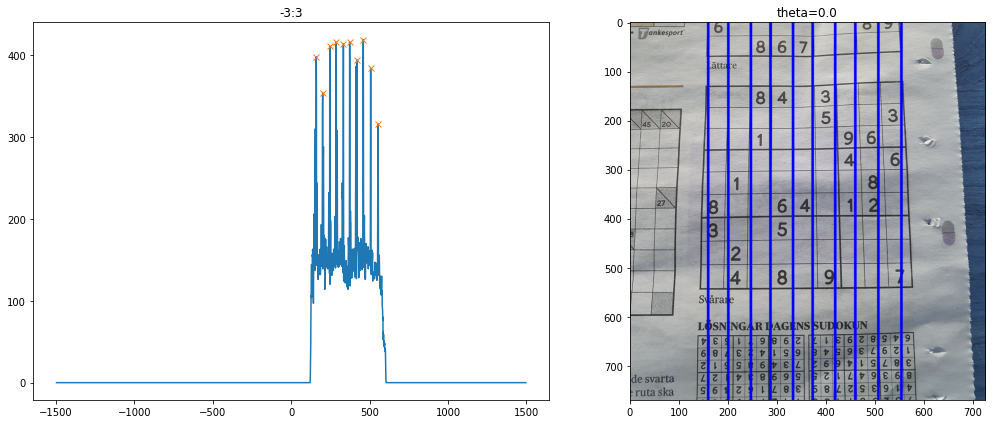

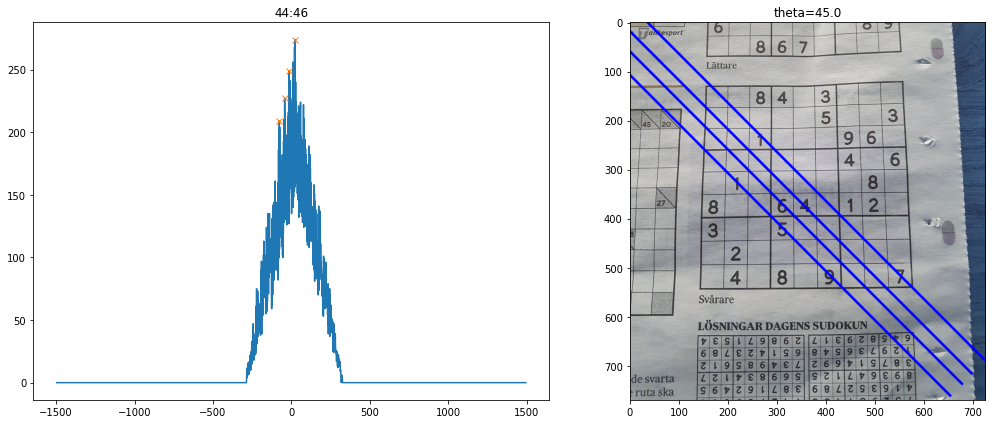

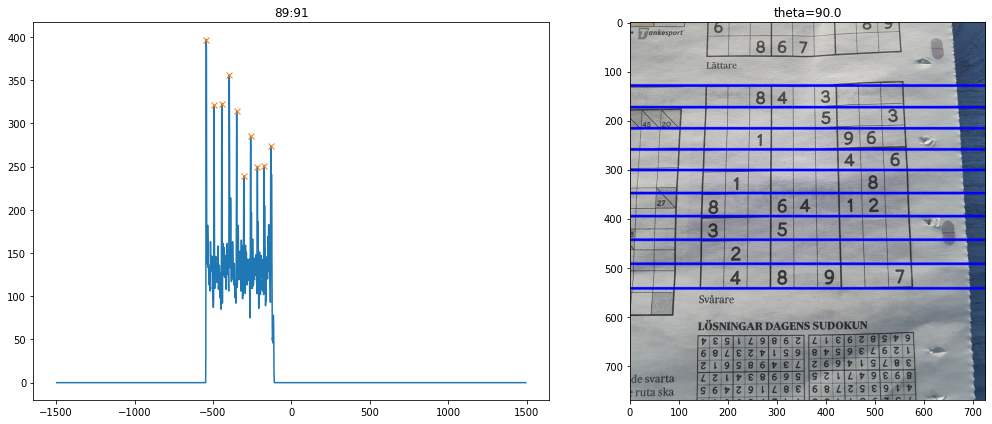

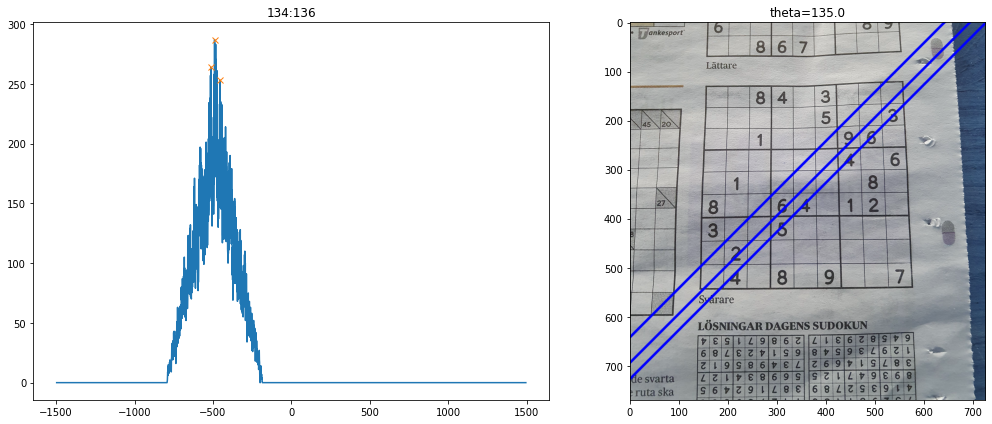

In [7]:
import scipy.signal
import math

accum_raw = accum.acc.copy()
rows, cols = accum_raw.shape
tops = ((0, 3), (45, 1), (90, 1), (135, 1))
for mid, width in tops:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    a = mid - width
    b = mid + width
    if a < 0:
        acc = np.vstack((accum_raw[a:], accum_raw[0:b]))
    elif b > rows:
        acc = np.vstack((accum_raw[a:], accum_raw[0:b-rows]))
    else:
        acc = accum_raw[a:b]
    ys = np.amax(acc, axis=0)
    # ys_bg = scipy.signal.medfilt(ys, 11)
    xs = np.arange(len(ys))
    xs = xs - len(xs) / 2
    y_max = np.amax(ys)
    ax1.plot(xs, ys)
    ax1.set_title(f"{a}:{b}")
    fig.set_size_inches(15, 6)
    fig.set_tight_layout(True)
    img_copy = img.copy()

    theta = sum((a, b)) / 2
    rhos, _ = scipy.signal.find_peaks(ys, distance=20, prominence=100)
    ax1.plot(xs[rhos], ys[rhos], 'x')
    for rho in xs[rhos]:
        a = math.cos(theta * math.pi / 180)
        b = -math.sin(theta * math.pi / 180)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*b), int(y0 - 1000*a))
        pt2 = (int(x0 - 1000*b), int(y0 + 1000*a))
        cv2.line(img_copy, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
    ax2.imshow(img_copy)
    ax2.set_title(f"theta={theta}")